In [1]:

import pandas as pd
import json
import os
os.environ['USER'] = "rmoine"
from pathlib import Path
import numpy as np
from typing import *
from llama.main import compute_metrics_from_list, get_tokenizer, plot_confusion
import llama.main as m
from sklearn.metrics import auc, roc_curve
import tqdm
folder_name = "inference"
root = Path(f"../../data/{folder_name}/")

c:\Users\robin\miniconda3\envs\severityPrediction\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Import of import evaluate failed
Import of from pytorchtools import EarlyStopping failed


In [2]:
split = {}
split_per_type = {}
for dataset_choice in ["eclipse_72k","mozilla_200k"]:
    with open(f"../../data/split_{dataset_choice}.json") as fp:
        split_per_type[dataset_choice] = json.load(fp)
        split[dataset_choice] = {}
        for dataset_type, bug_ids in split_per_type[dataset_choice].items():
            for bug_id in bug_ids:
                split[dataset_choice][bug_id] = dataset_type

In [21]:

l = []
tokenizer = get_tokenizer(m.default_token, m.default_model)
pathes = list(root.rglob("inference__*"))
for path_data in tqdm.tqdm(pathes):
    with open(path_data / "parameters.json") as fp:
        parameters = json.load(fp)
    dataset_choice = parameters["dataset_choice"]
    files_data = list(path_data.rglob(f"predictions_*.json"))
    if len(files_data) == 0:
        continue
    for f in files_data:
        d = []
        with open(f) as fp:
            for line in fp.readlines():
                if line.strip() == '':
                    continue
                try:
                    line = json.loads(line)
                except Exception as e:
                    print(e)
                    print(line)
                    raise Exception
                l.append({
                    **line,
                    "dataset_type": split[dataset_choice][line['bug_id']],
                    "dataset_choice":dataset_choice,
                    "parameters":{**parameters,"path_data_folder": path_data.stem}, 
                    "prompt_id": parameters['prompt_id']}
                )
dfs = pd.DataFrame(l)
    


100%|██████████| 300/300 [12:45<00:00,  2.55s/it]   


In [22]:
dfs.to_json(root / "dfs.json")

In [3]:
dfs = pd.read_json(root / "dfs.json")

In [4]:
dfs.columns

Index(['input', 'n_tokens', 'tokenized', 'bug_id', 'bug_severity',
       'binary_severity', 'stemmed_description', 'description', 'answer',
       'severity_pred', 'dataset_type', 'dataset_choice', 'parameters',
       'prompt_id'],
      dtype='object')

In [5]:
missing_bug_id_in_df = {}
ref_severities = {}
datasets = {}
for d in ["eclipse_72k","mozilla_200k"]:
    with open(root / f"../llm/{d}.json") as fp:
        datasets[d] = json.load(fp)
df_preprocessed = dfs.copy()
for (dataset_choice, dataset_type, prompt_id), group in dfs.drop_duplicates(subset=["dataset_choice", "dataset_type", "prompt_id", "bug_id"]).groupby(["dataset_choice", "dataset_type", "prompt_id"]):
    print(dataset_choice, dataset_type, prompt_id)
    missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)] = set(split_per_type[dataset_choice][dataset_type]) - set(group["bug_id"].unique())
    if len(missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)]) > 0:
        if dataset_choice not in ref_severities:
            ref_severities[dataset_choice] = {}
        to_add = []
        for dico in datasets[dataset_choice]:
            if dico["bug_id"] in missing_bug_id_in_df[(dataset_choice, dataset_type, prompt_id)]:
                to_add.append({
                    "dataset_choice":dataset_choice, 
                    "dataset_type":dataset_type, 
                    "prompt_id":prompt_id, 
                    "severity_pred": -2, 
                    "binary_severity": dico["binary_severity"],
                    "bug_id": dico["bug_id"],
                })
        df_preprocessed = pd.concat([df_preprocessed,pd.DataFrame(to_add, columns=df_preprocessed.columns)], ignore_index=True)
group_cols = ["dataset_choice", "dataset_type", "prompt_id"]

df_preprocessed = df_preprocessed.drop_duplicates([*group_cols, "bug_id"])
df_preprocessed.groupby(group_cols).agg(len)["bug_id"]

eclipse_72k test alpaca
eclipse_72k test official
eclipse_72k tr alpaca
eclipse_72k tr official
eclipse_72k val alpaca
eclipse_72k val official
mozilla_200k test alpaca
mozilla_200k test official
mozilla_200k tr alpaca
mozilla_200k tr official
mozilla_200k val alpaca
mozilla_200k val official


dataset_choice  dataset_type  prompt_id
eclipse_72k     test          alpaca         7220
                              official       7220
                tr            alpaca        50534
                              official      50534
                val           alpaca        14438
                              official      14438
mozilla_200k    test          alpaca        19951
                              official      19951
                tr            alpaca       139651
                              official     139651
                val           alpaca        39901
                              official      39901
Name: bug_id, dtype: int64

In [6]:
df_counts = pd.DataFrame({(dataset_choice,dataset_type): [] for dataset_choice in df_preprocessed["dataset_choice"].unique() for dataset_type in ["tr","val","test"]})
groups_no_prompt = df_preprocessed.groupby(["dataset_choice","dataset_type"])
for (dataset_choice, dataset_type), group_data in groups_no_prompt:
    tot_samples_dataset = sum(len(v) for v in split_per_type[dataset_choice].values())
    print(dataset_choice, dataset_type,len(group_data), tot_samples_dataset, len(group_data))
    df_counts.at["Absolute", (dataset_choice, dataset_type)] = len(group_data)/2
    df_counts.at["Percentage of dataset", (dataset_choice, dataset_type)] = np.round(len(group_data)/2/tot_samples_dataset*100,decimals=0)
# df_counts = df_counts.astype(int)
display(df_counts)

eclipse_72k test 14440 72192 14440
eclipse_72k tr 101068 72192 101068
eclipse_72k val 28876 72192 28876
mozilla_200k test 39902 199503 39902
mozilla_200k tr 279302 199503 279302
mozilla_200k val 79802 199503 79802


eclipse_72k                  mozilla_200k           \
                               tr      val    test           tr      val   
Absolute                  50534.0  14438.0  7220.0     139651.0  39901.0   
Percentage of dataset        70.0     20.0    10.0         70.0     20.0   

                                
                          test  
Absolute               19951.0  
Percentage of dataset     10.0

In [7]:
groups = df_preprocessed.groupby(group_cols)


  0%|          | 0/12 [00:00<?, ?it/s]

official, mozilla_200k, val: 100%|██████████| 12/12 [2:50:28<00:00, 852.41s/it]

alpaca, eclipse_72k, test:   0%|          | 0/12 [00:06<?, ?it/s]

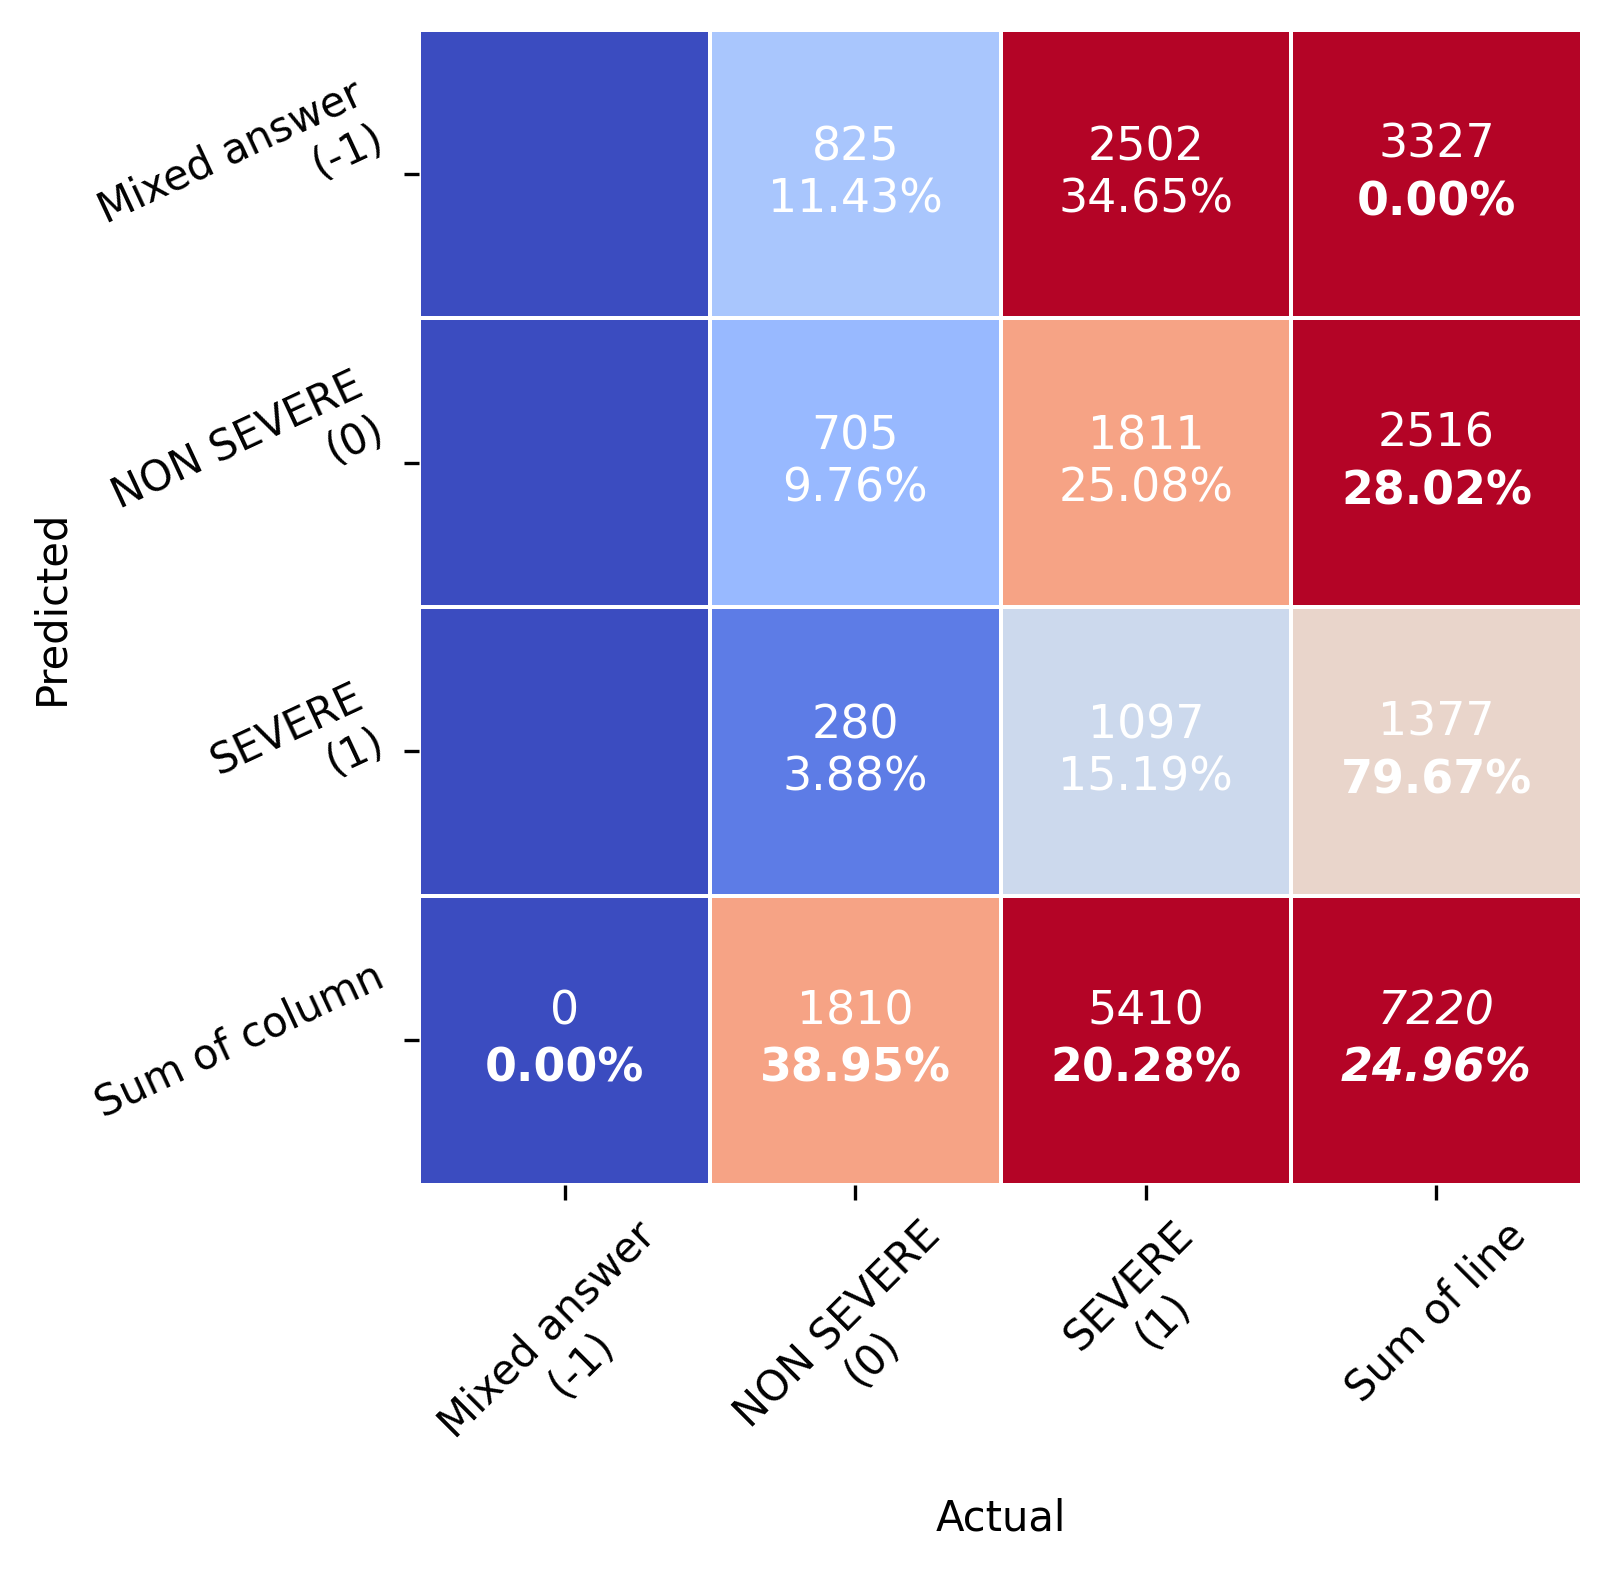


official, eclipse_72k, test:   8%|▊         | 1/12 [00:07<01:19,  7.27s/it]

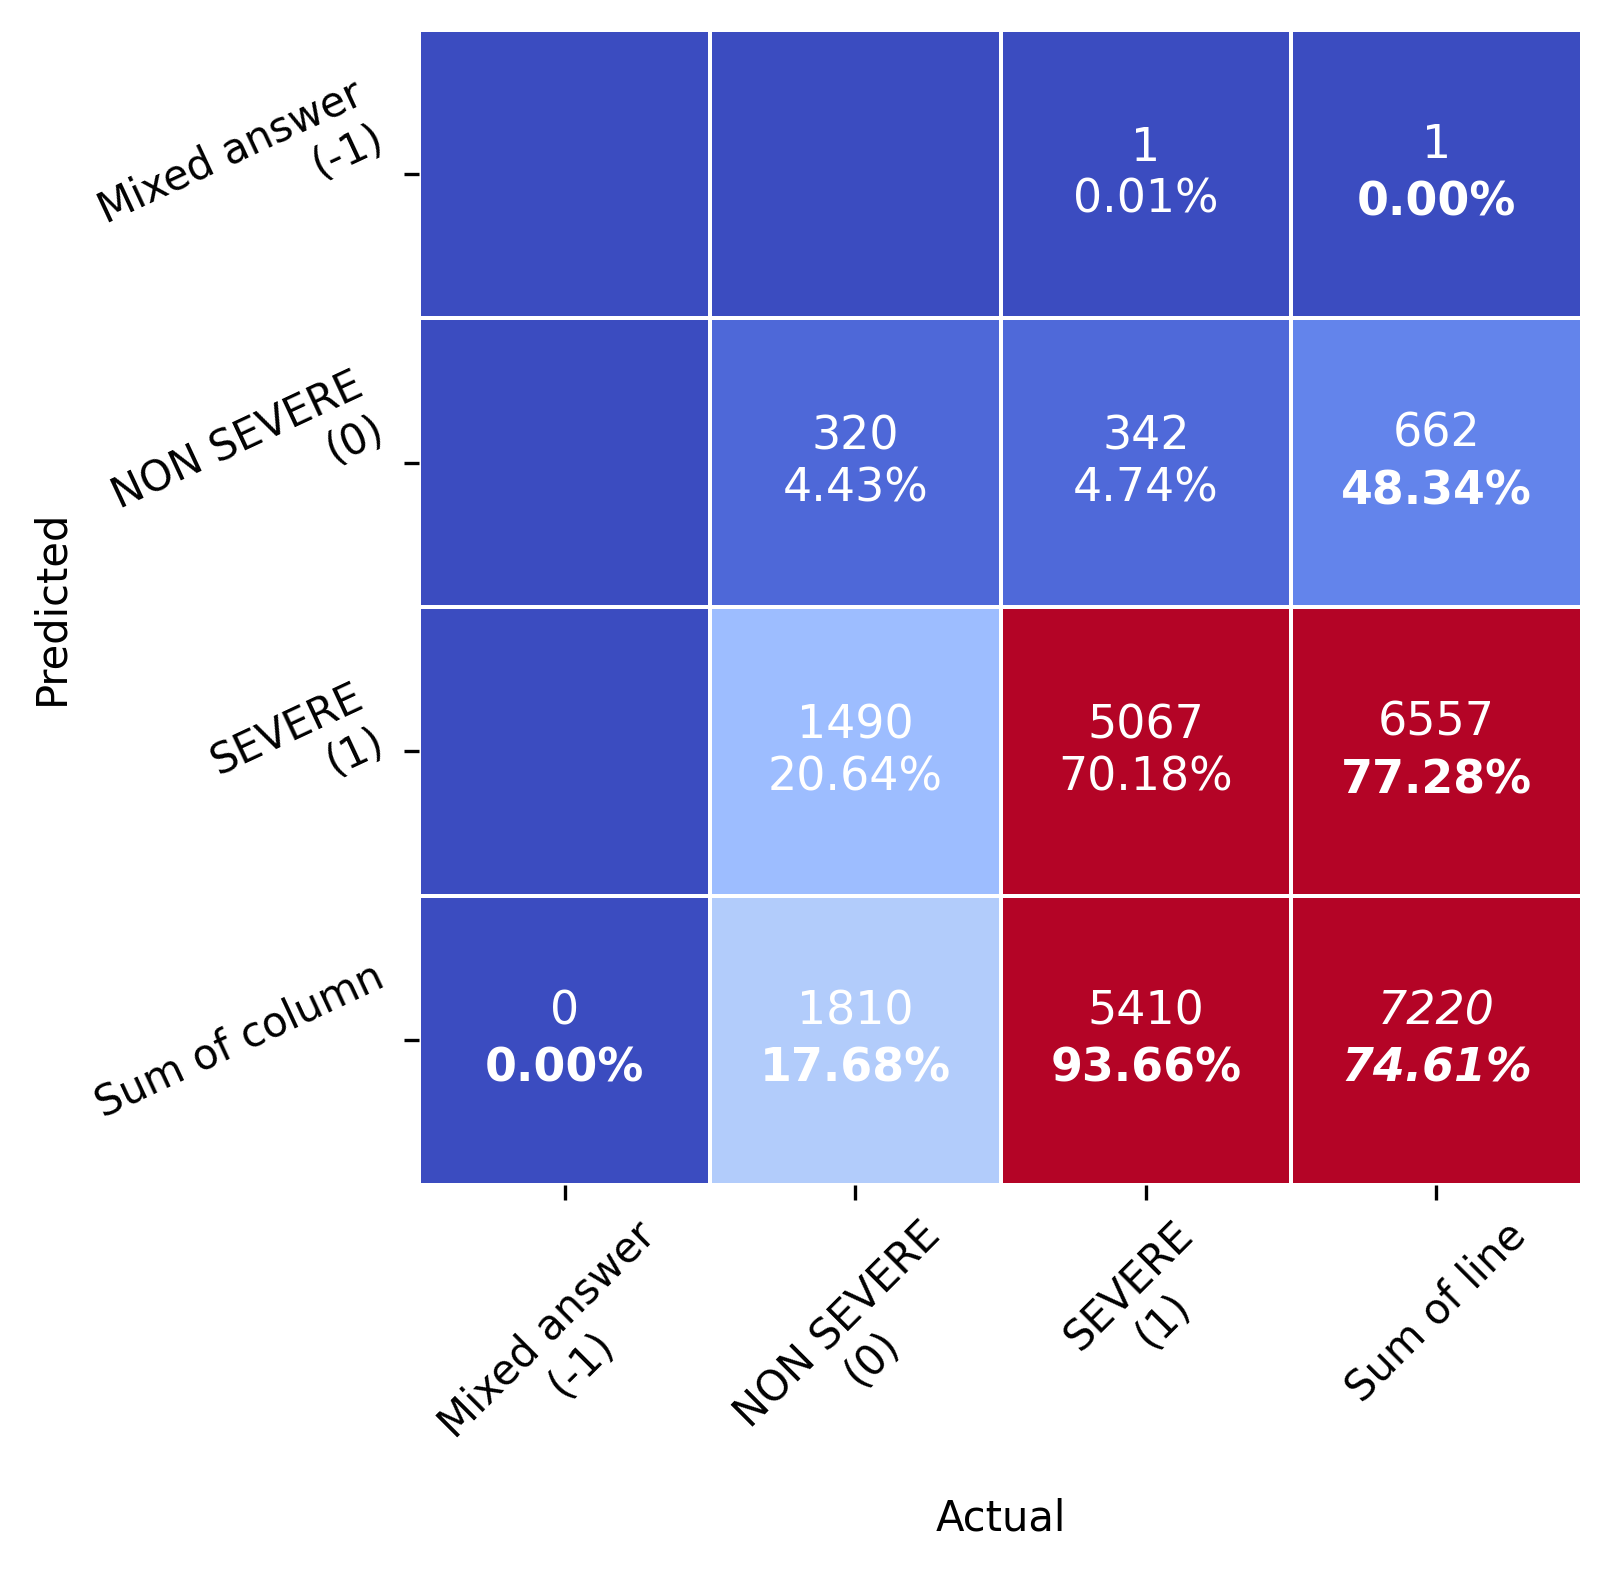


alpaca, eclipse_72k, tr:  17%|█▋        | 2/12 [00:07<00:34,  3.42s/it]    

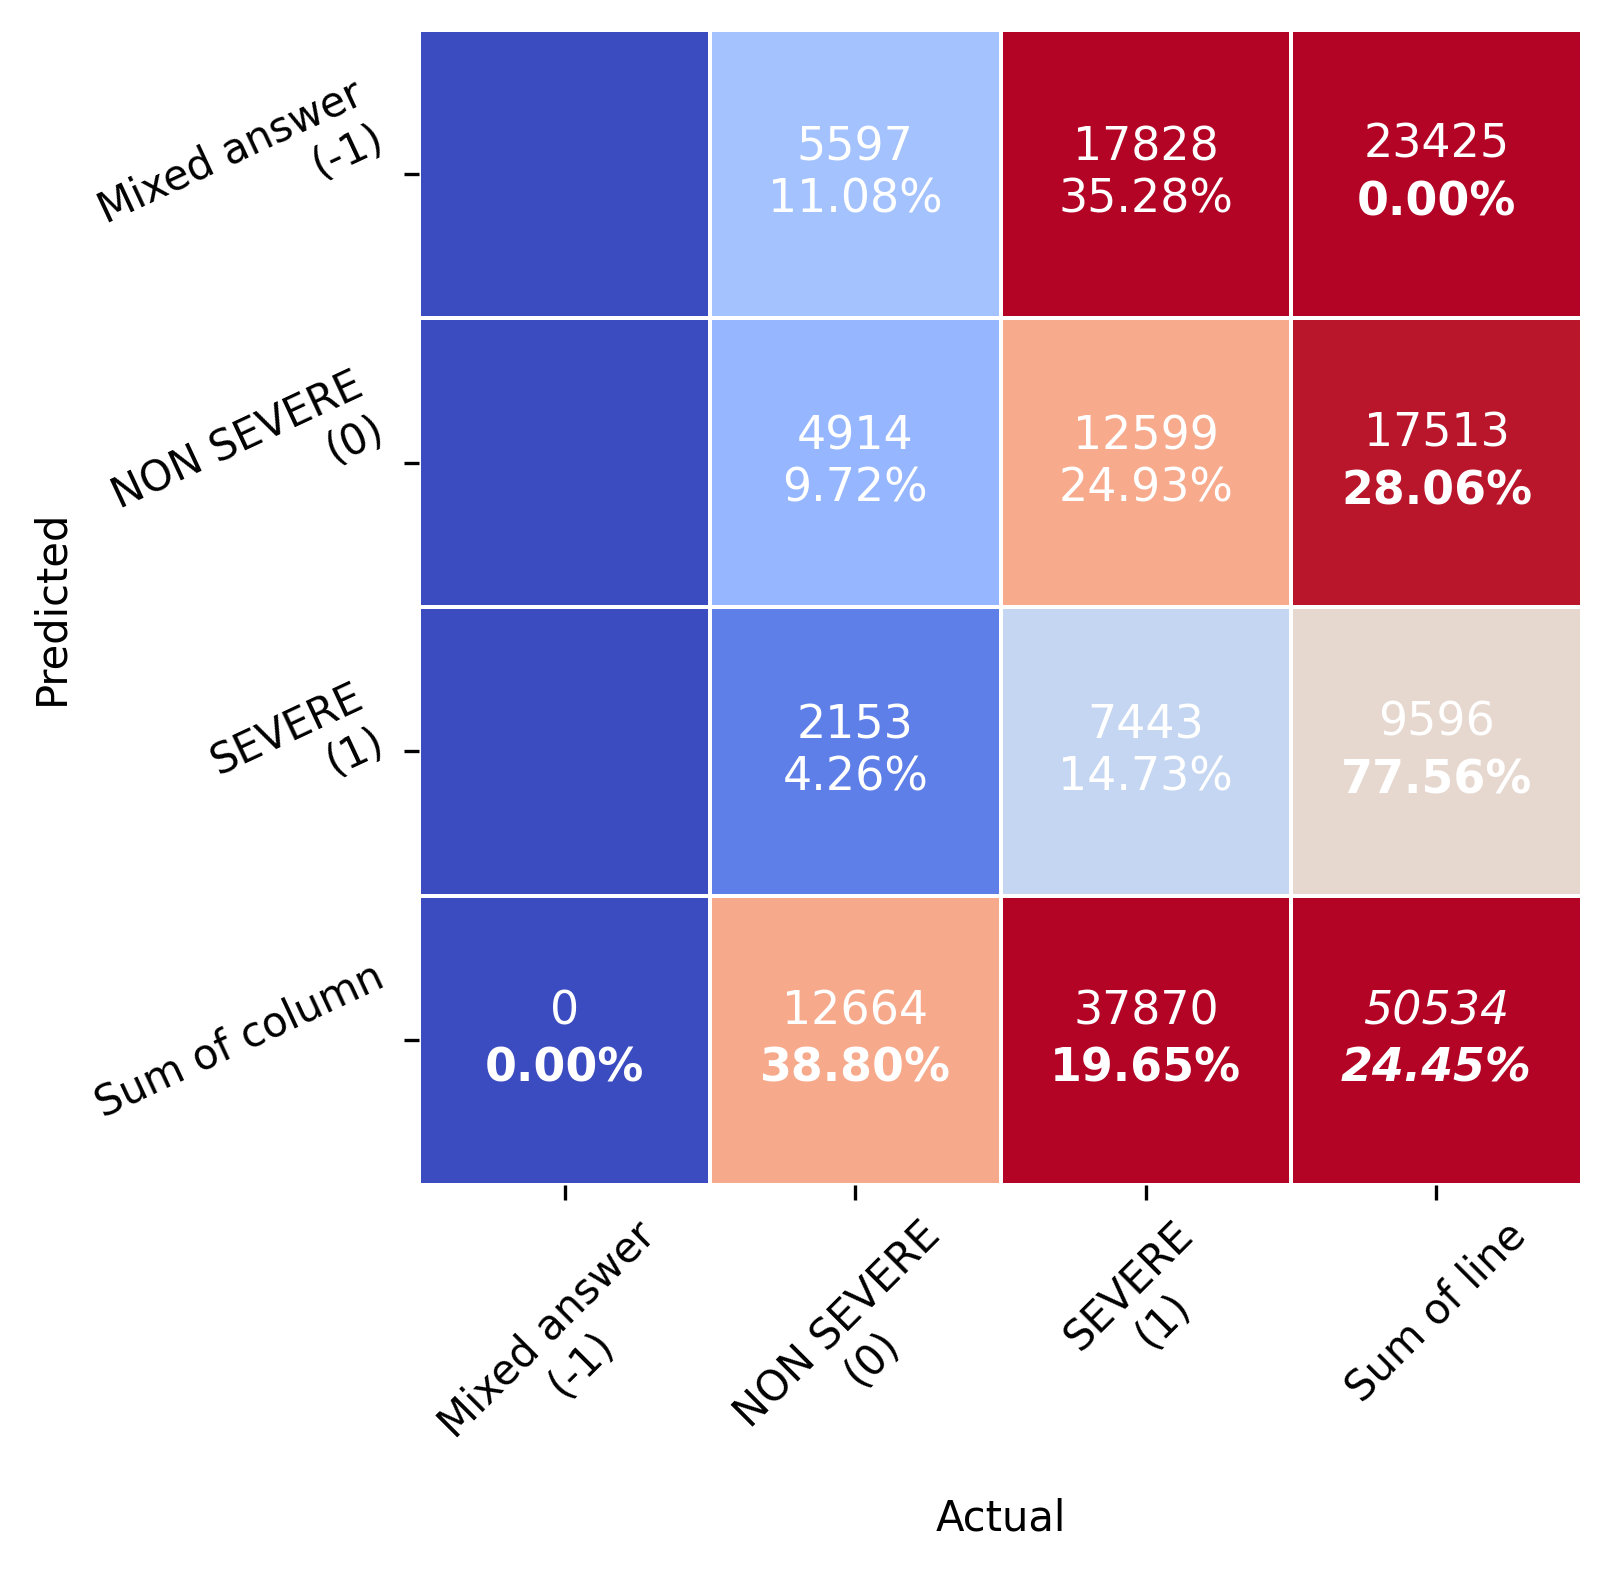


official, eclipse_72k, tr:  25%|██▌       | 3/12 [00:09<00:23,  2.59s/it]

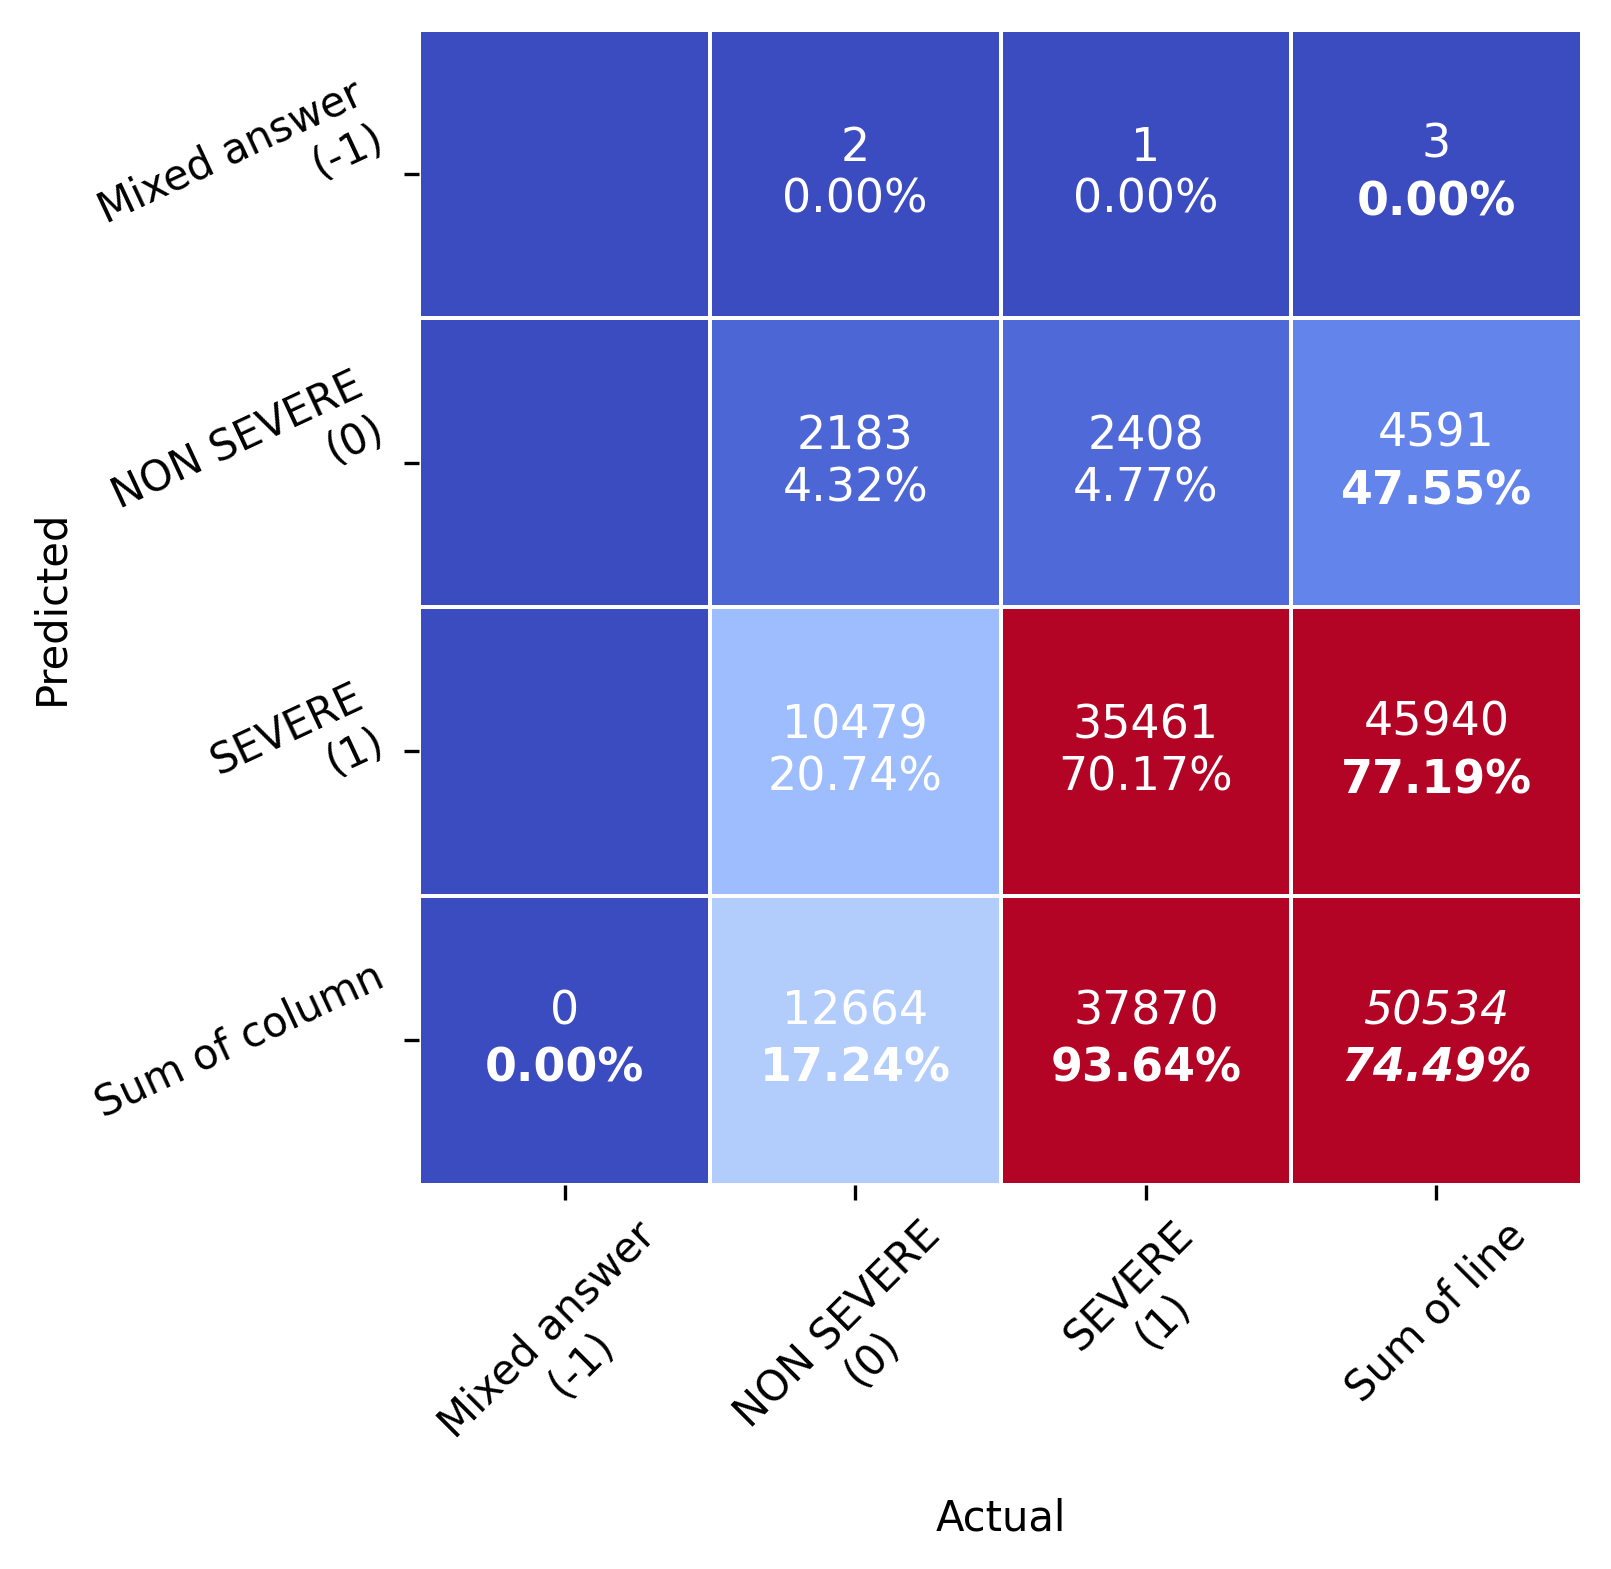


alpaca, eclipse_72k, val:  33%|███▎      | 4/12 [00:11<00:17,  2.19s/it] 

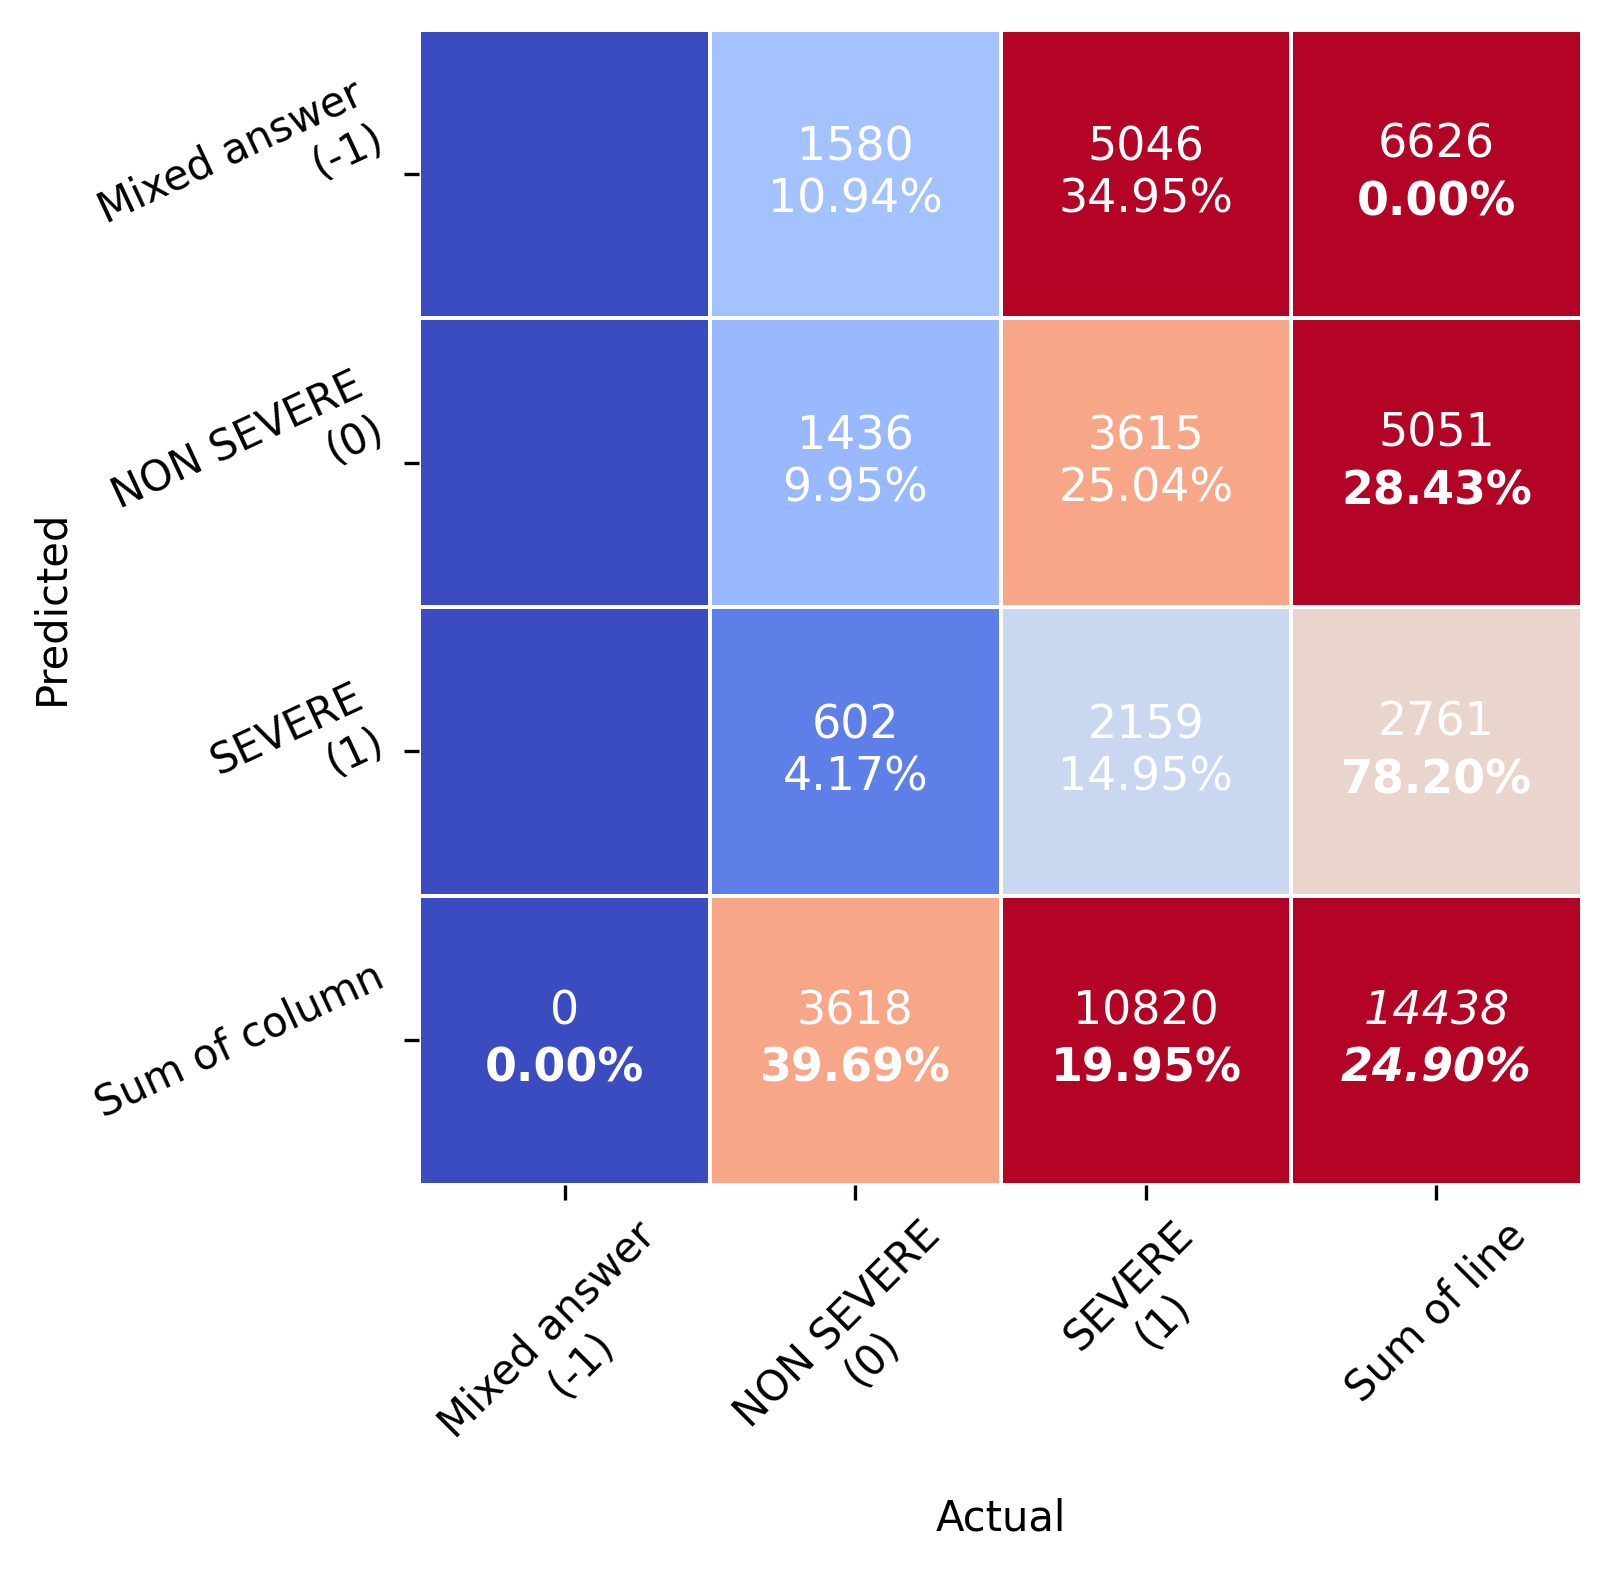


official, eclipse_72k, val:  42%|████▏     | 5/12 [00:11<00:11,  1.69s/it]

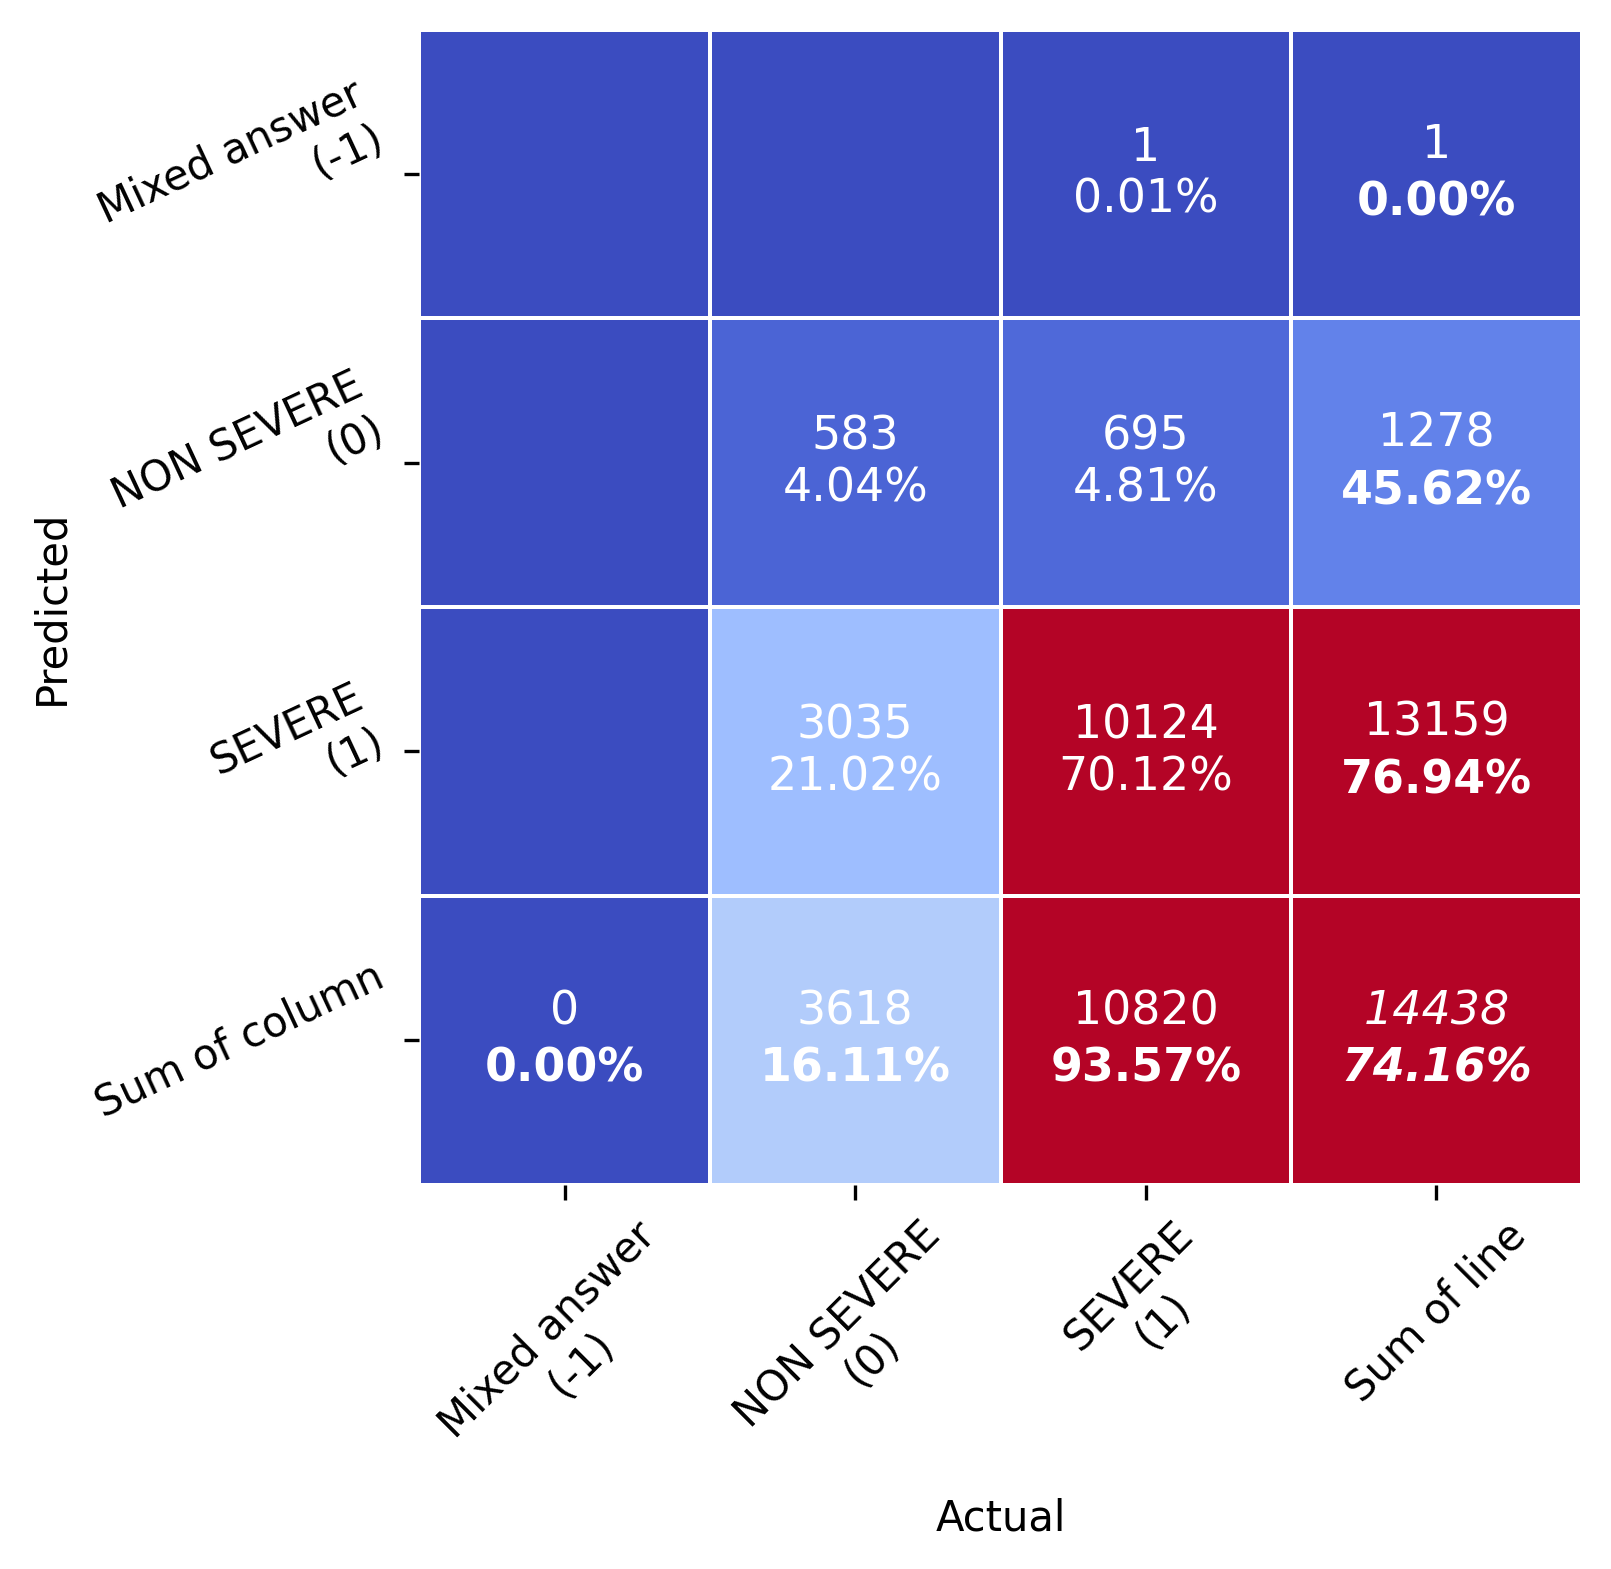


alpaca, mozilla_200k, test:  50%|█████     | 6/12 [00:12<00:08,  1.39s/it]

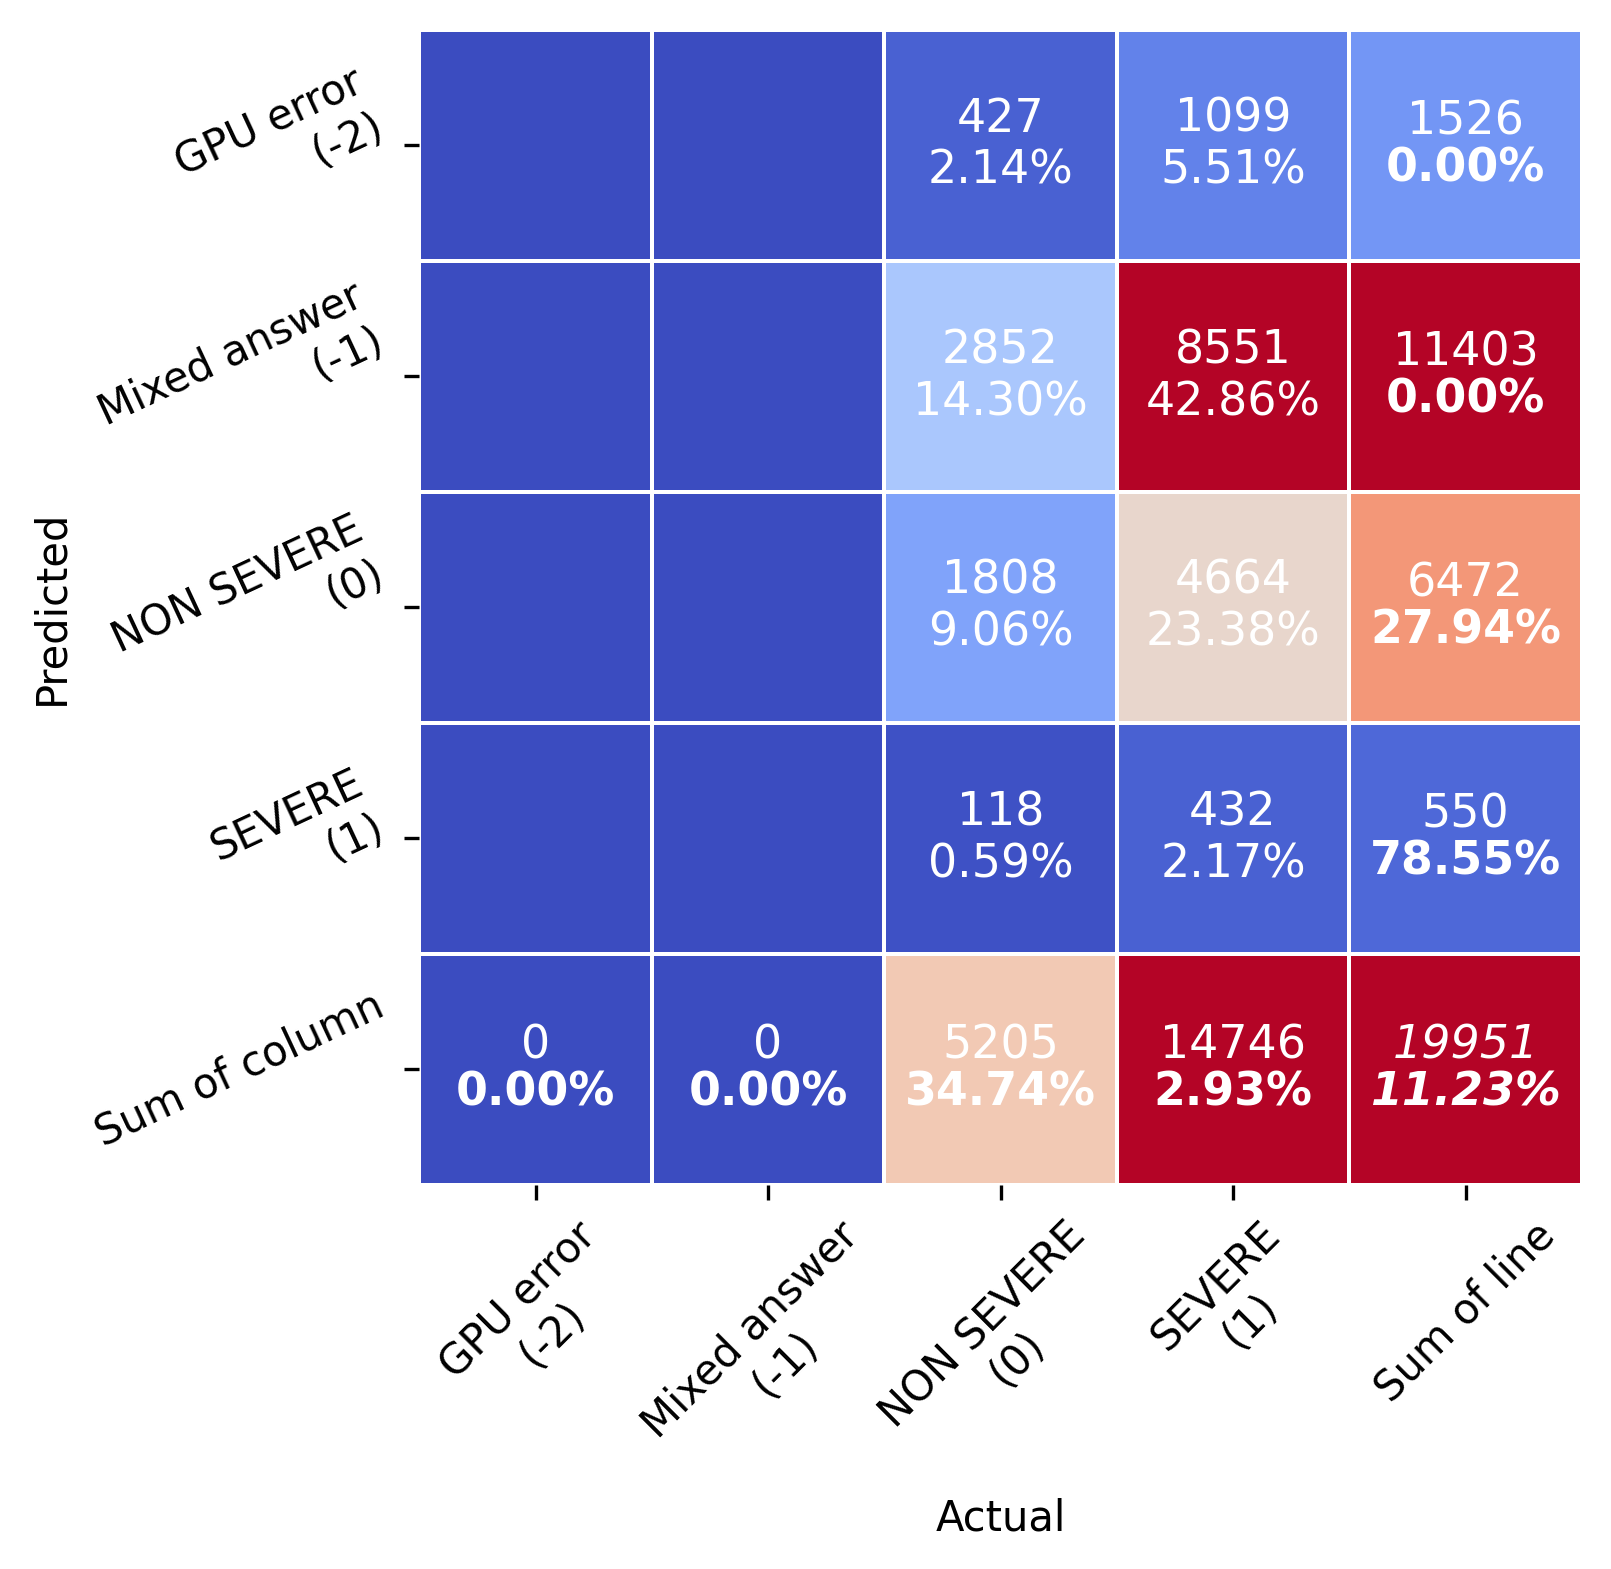


official, mozilla_200k, test:  58%|█████▊    | 7/12 [00:13<00:06,  1.26s/it]

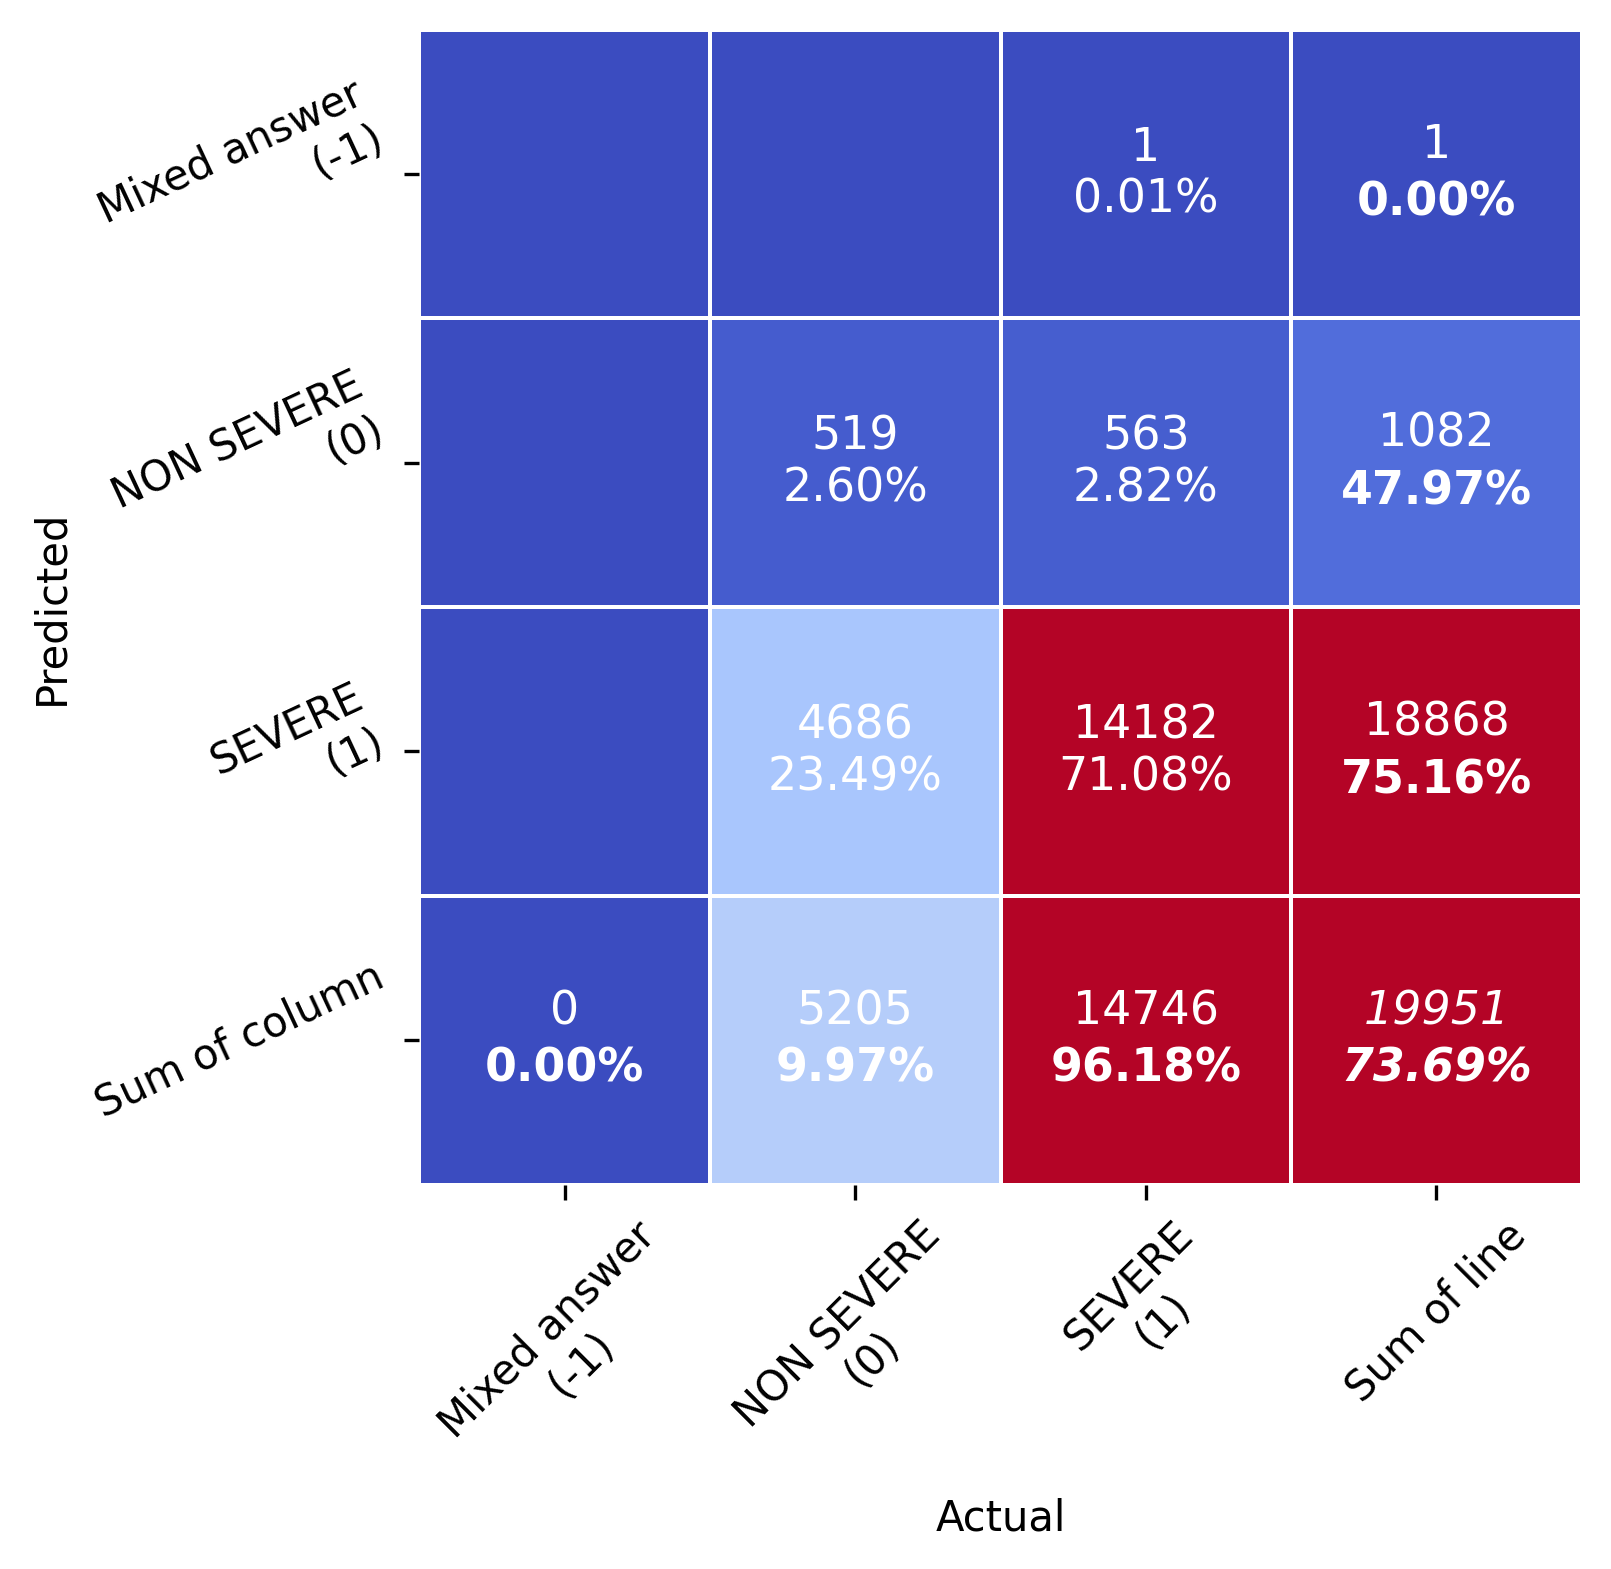


alpaca, mozilla_200k, tr:  67%|██████▋   | 8/12 [00:14<00:04,  1.15s/it]    

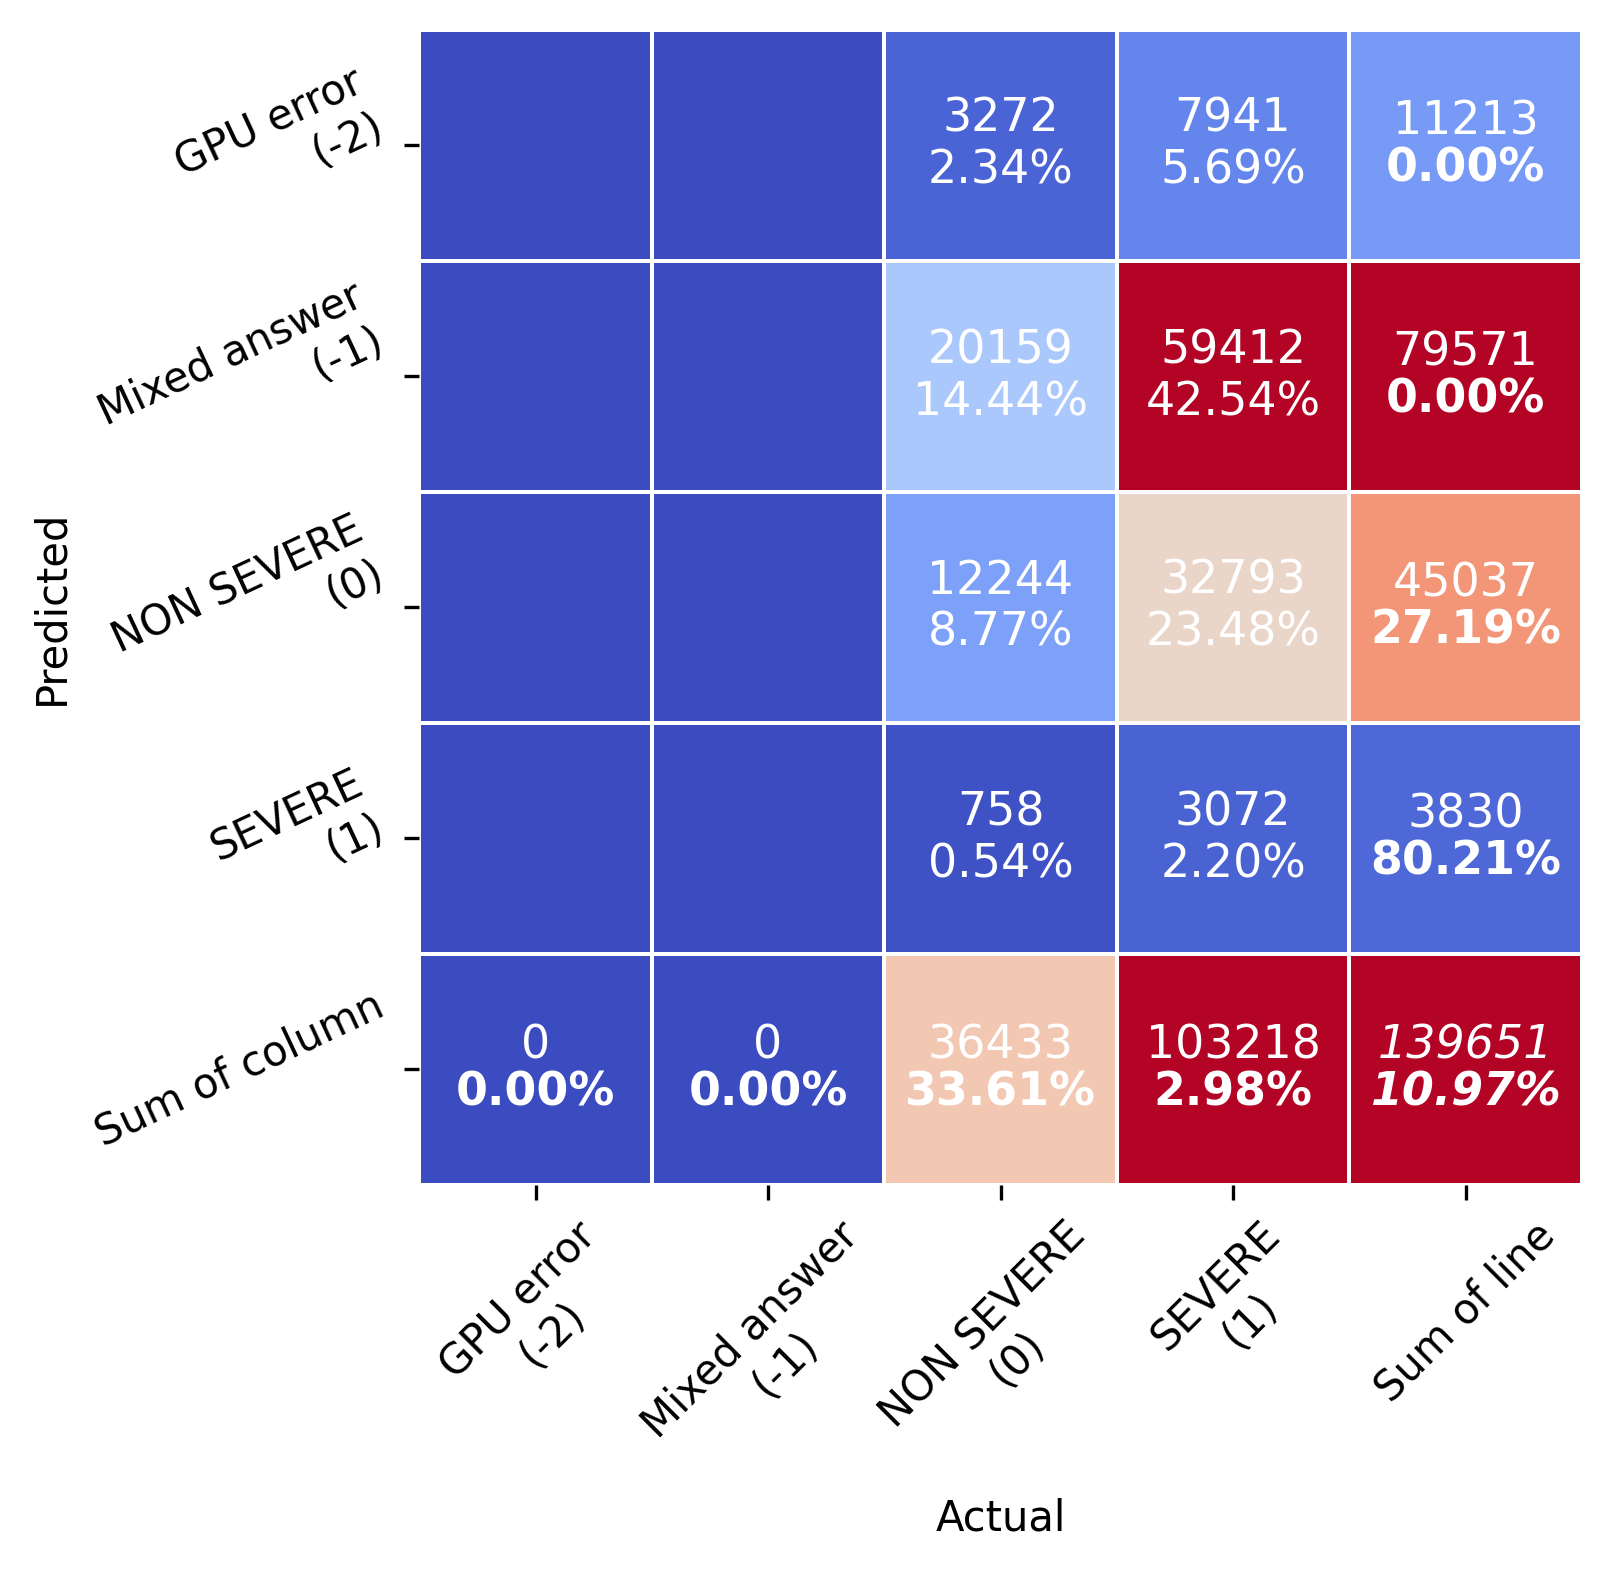


official, mozilla_200k, tr:  75%|███████▌  | 9/12 [01:10<00:54, 18.08s/it]

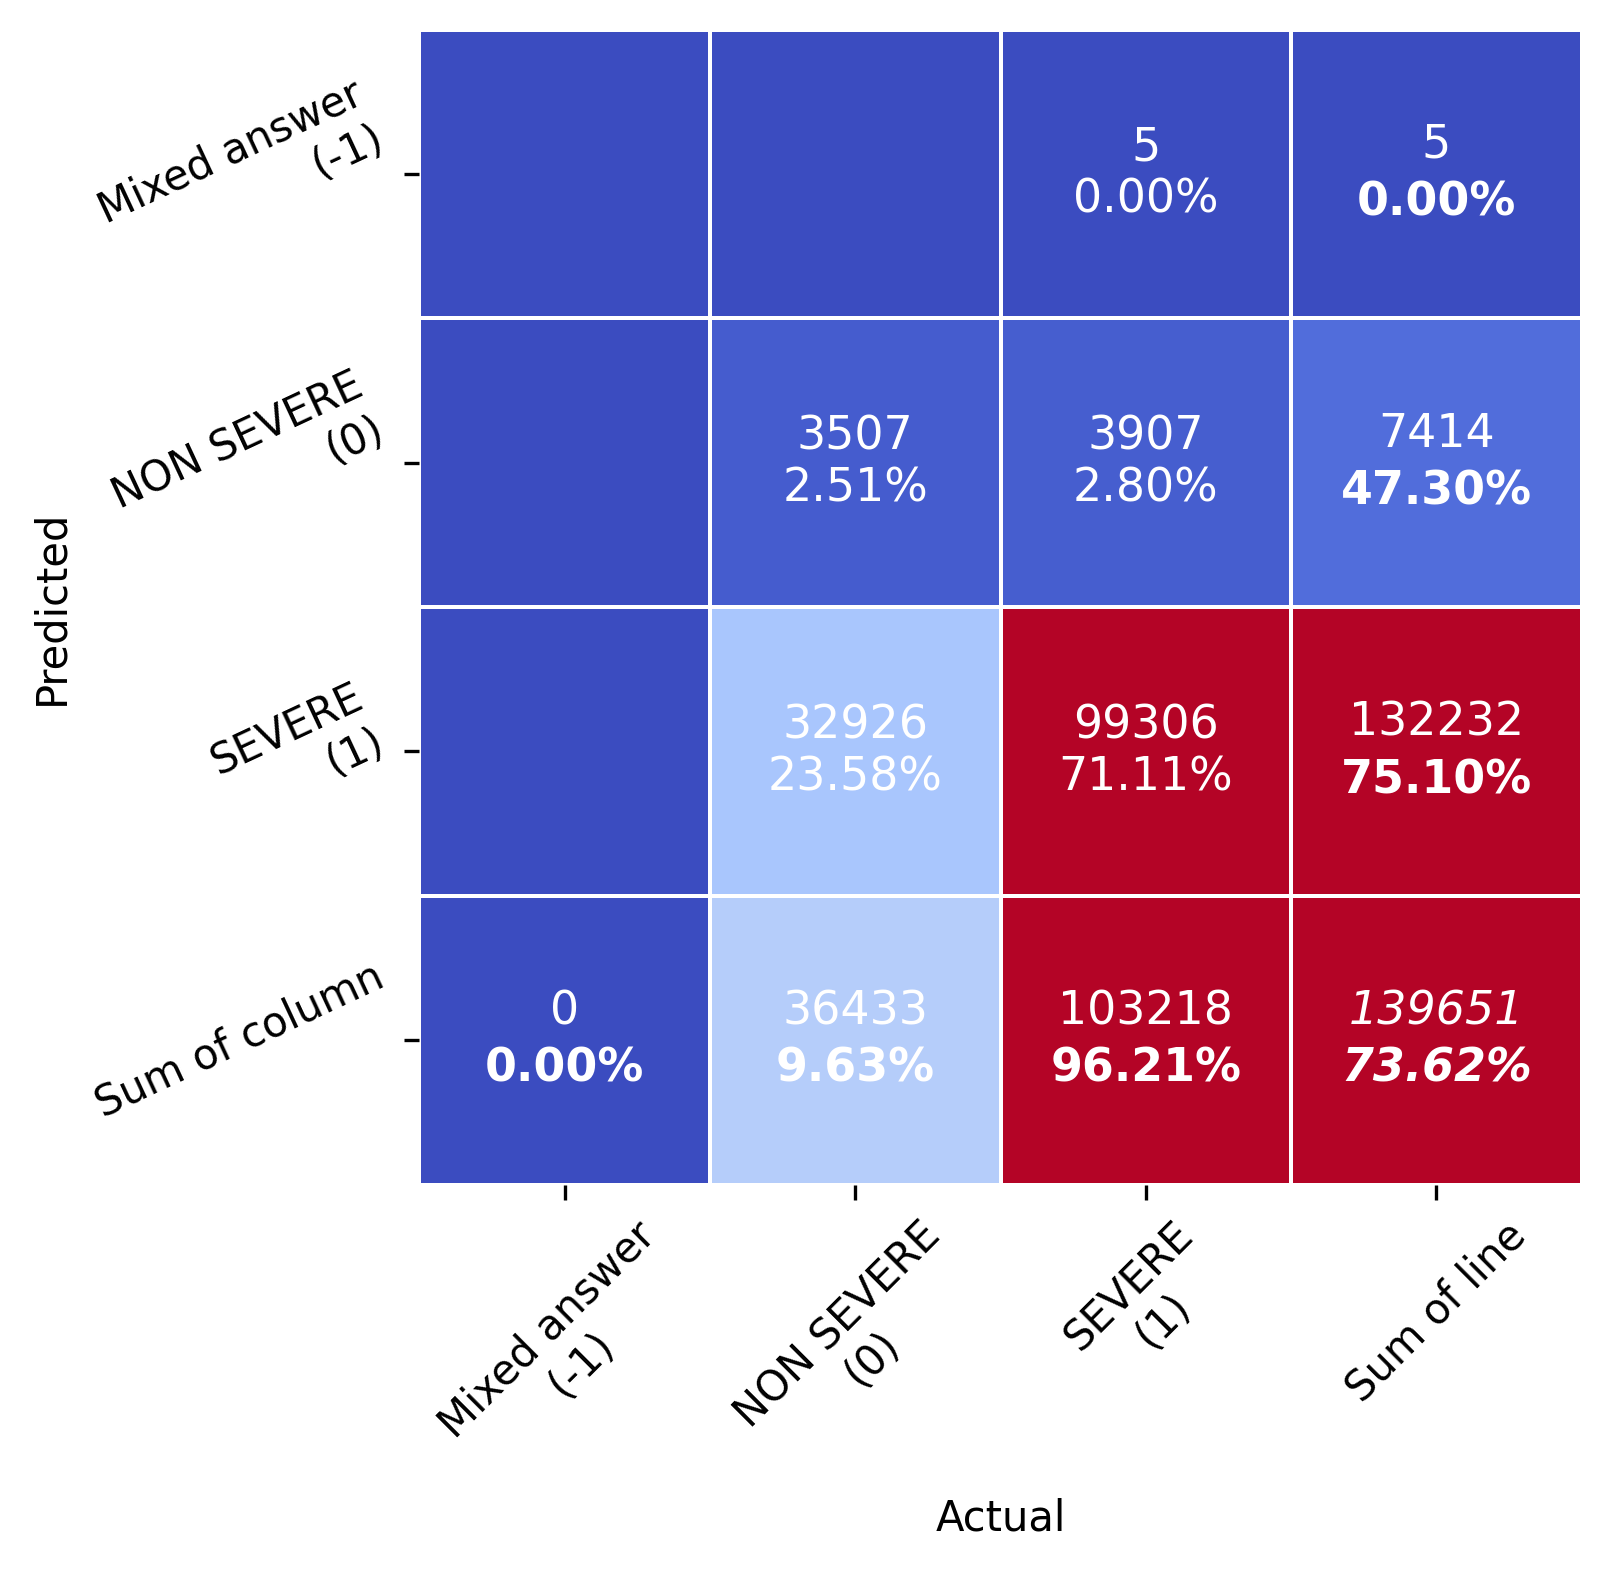


alpaca, mozilla_200k, val:  83%|████████▎ | 10/12 [01:17<00:29, 14.78s/it] 

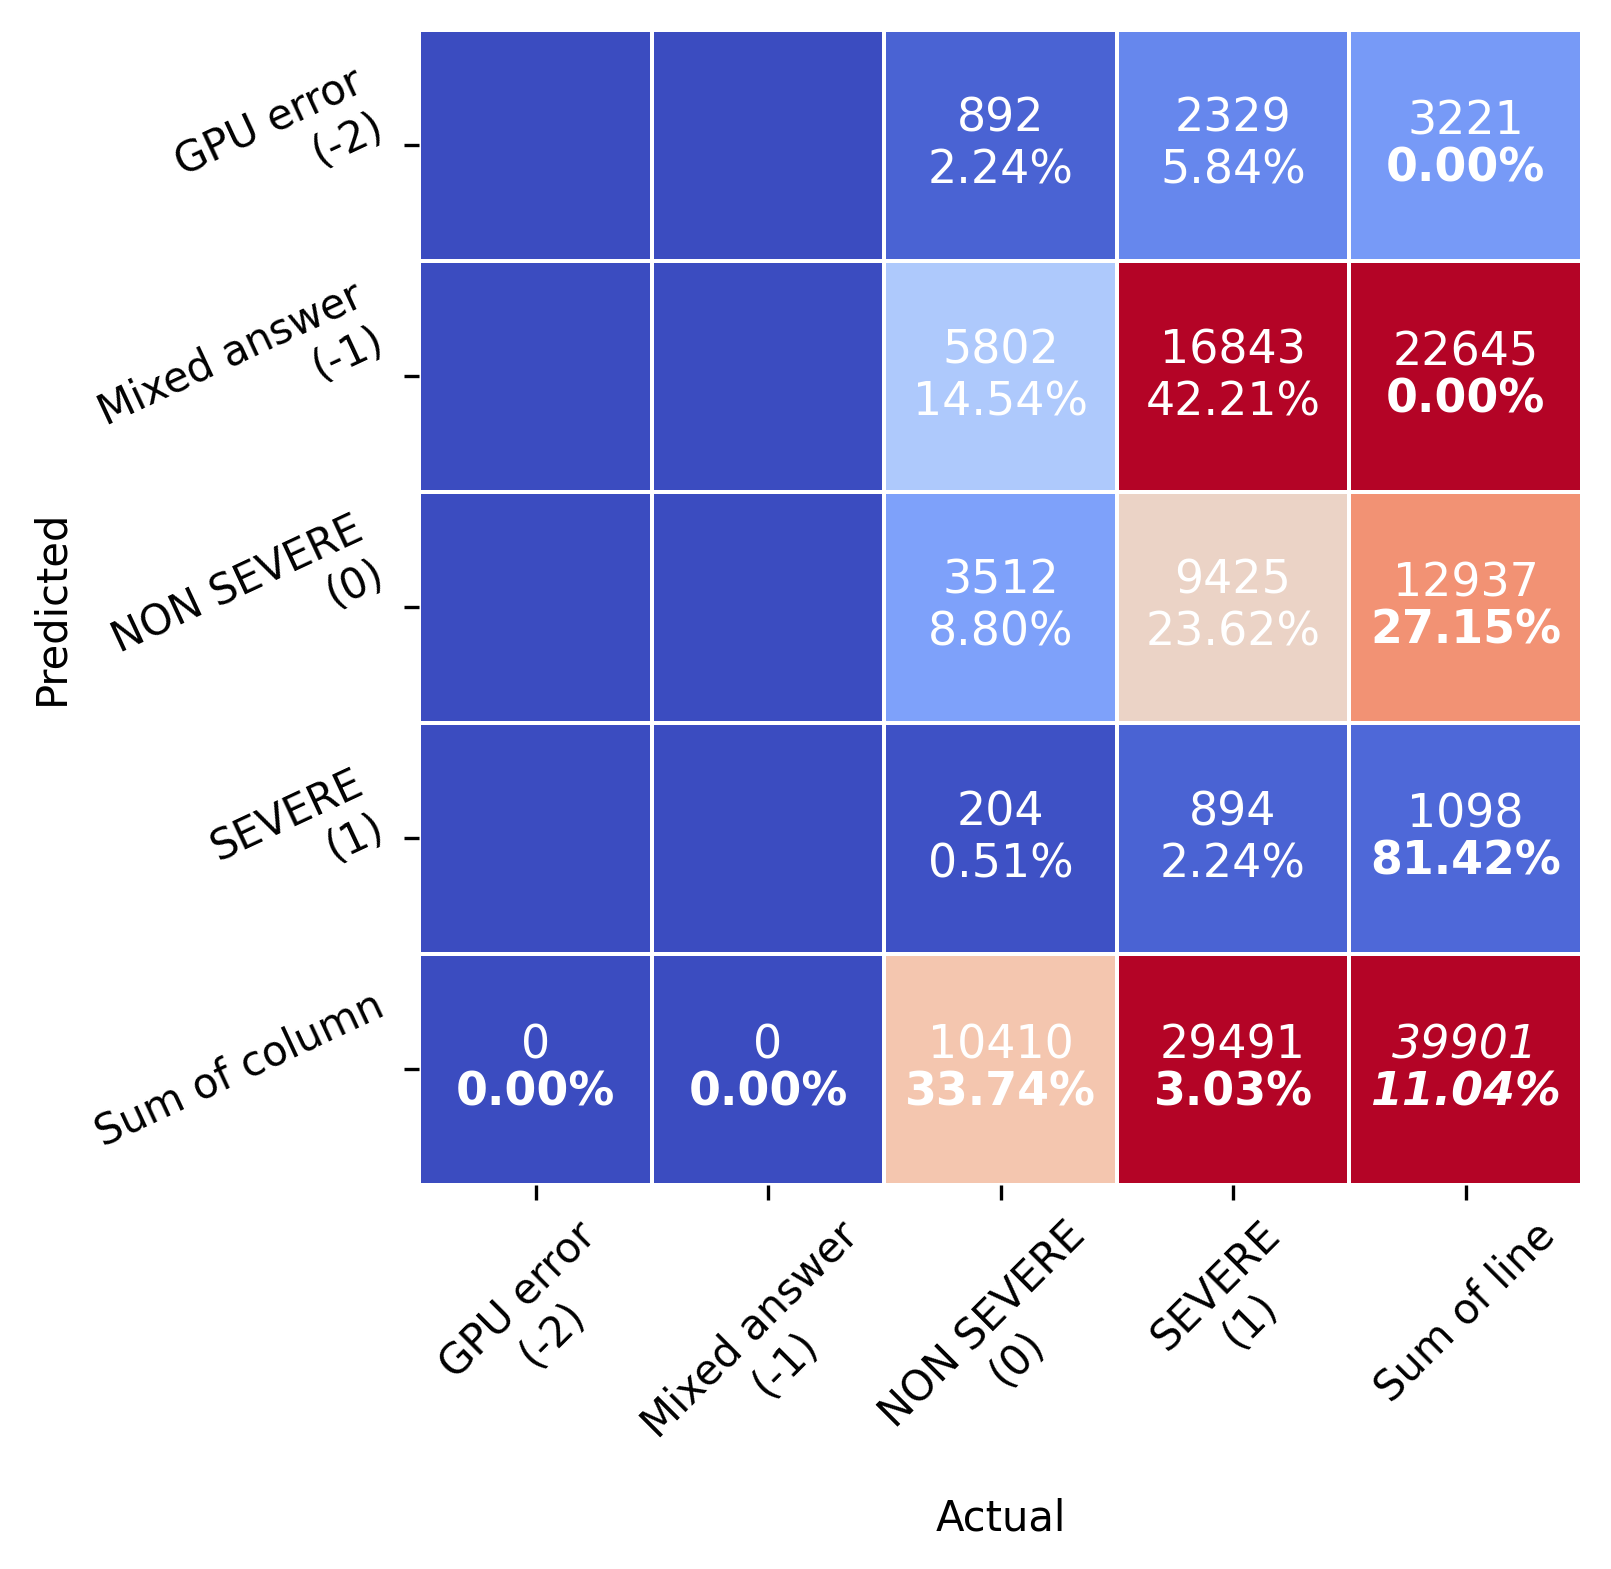


official, mozilla_200k, val:  92%|█████████▏| 11/12 [01:57<00:22, 22.46s/it]

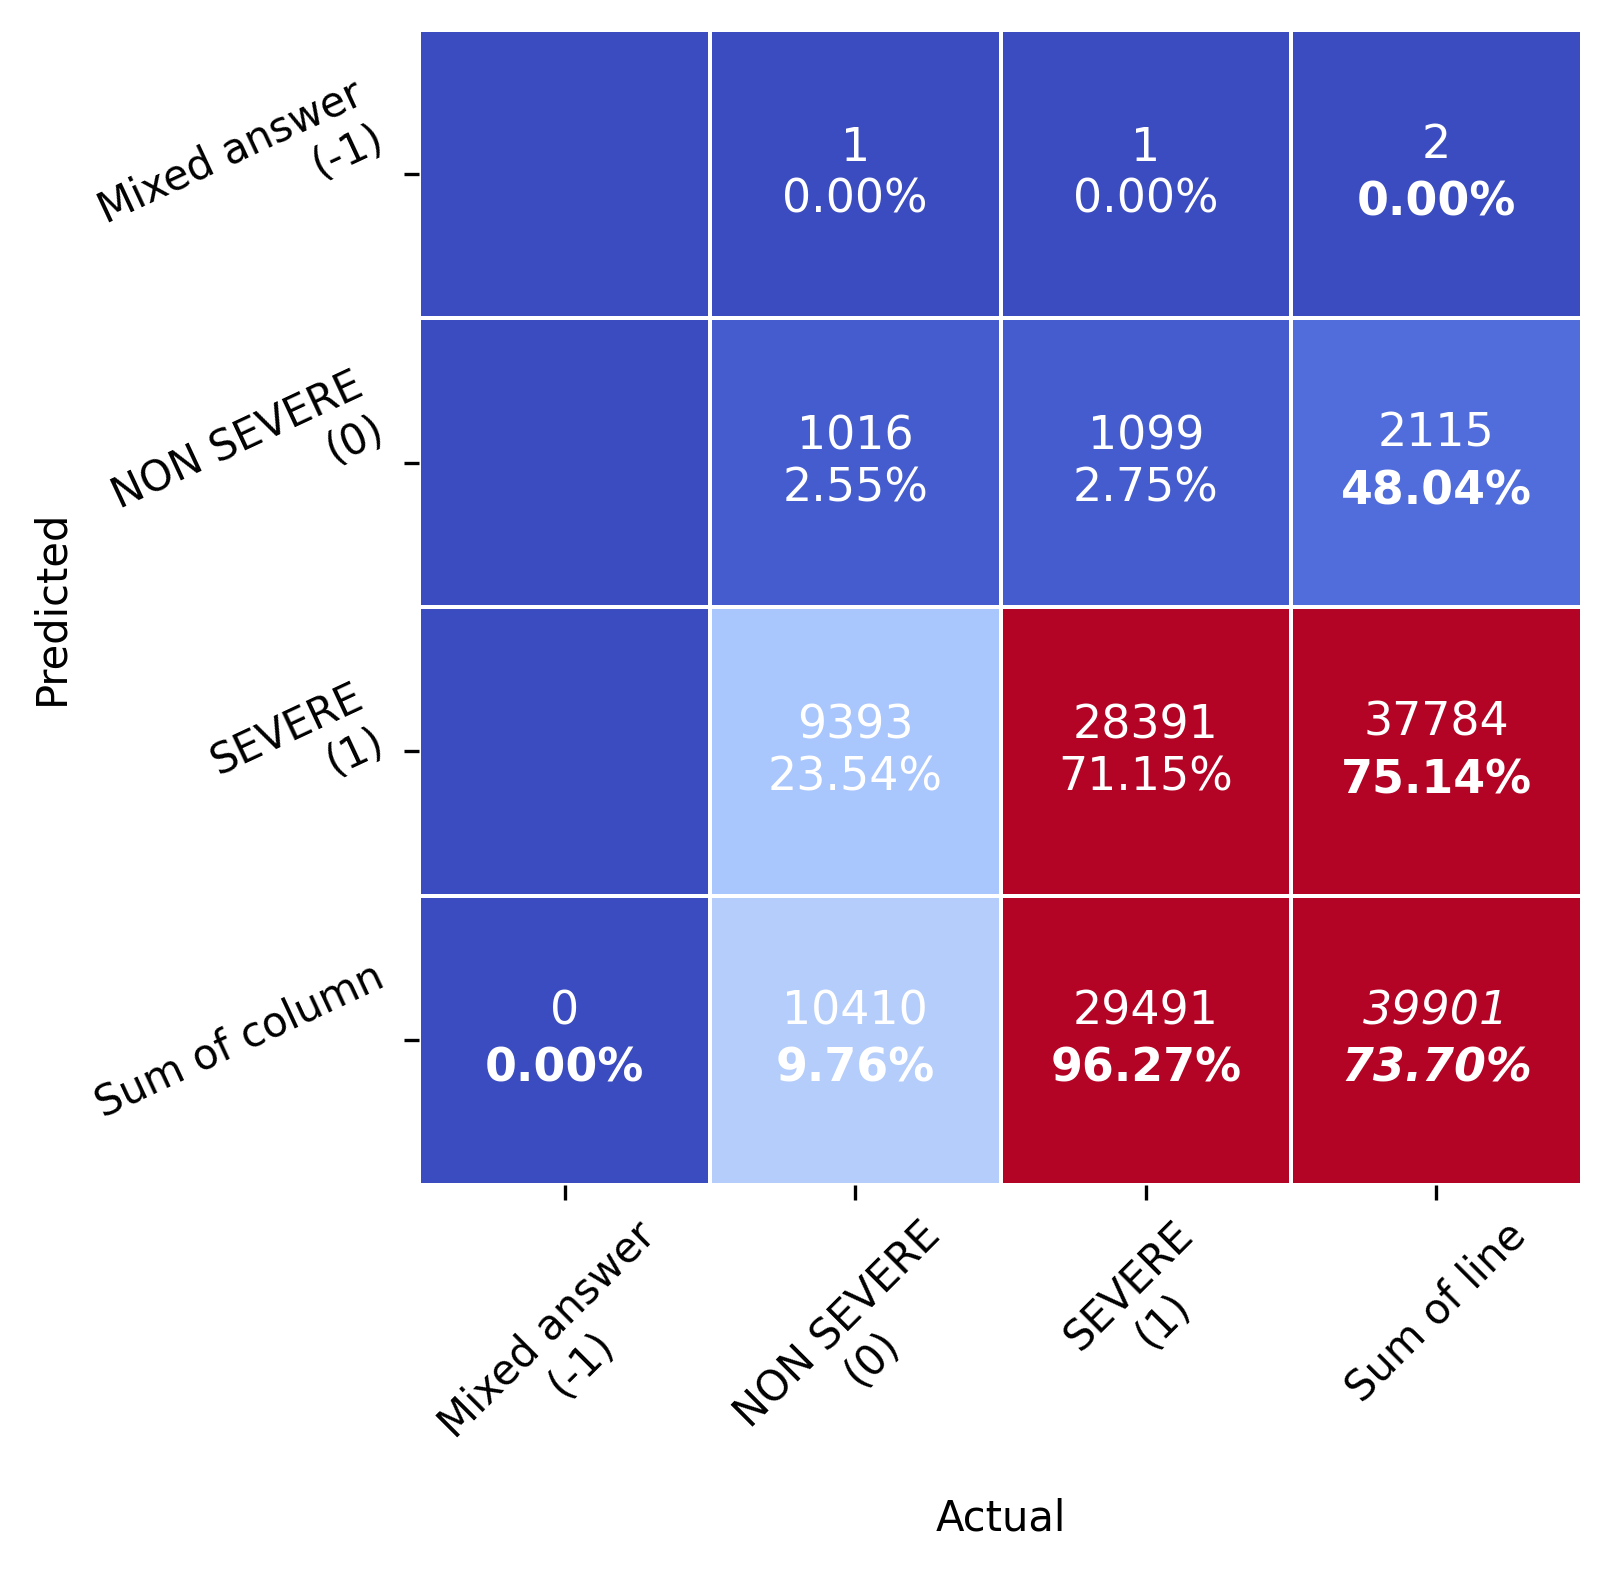


official, mozilla_200k, val: 100%|██████████| 12/12 [01:59<00:00, 16.22s/it]

In [9]:
l = []
progress = tqdm.tqdm(total=len(groups))
for (dataset_choice, dataset_type, prompt_id), group_data in (groups):
    progress.set_description(f"{prompt_id}, {dataset_choice}, {dataset_type}")
    d = group_data.to_dict(orient="records")
    prompt_id = d[0]['prompt_id']
    n_tokens_infered_max = 1000
    confusion_matrix, f1, data_full = compute_metrics_from_list(d, pred_field="severity_pred",)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    df1 = pd.DataFrame(d)
    try:
        fpr, tpr, thresholds = roc_curve(y_true=np.array(df1['binary_severity']), y_score=np.array(df1['severity_pred']))
        roc_auc = auc(fpr, tpr)
        l.append({"n_elems": len(d), "n_tokens_infered_max": n_tokens_infered_max, "roc_auc":roc_auc, "dataset_choice": dataset_choice, "dataset_type":dataset_type,"confusion_matrix":confusion_matrix,"f1":f1,"accuracy":accuracy*100, **d[0]["parameters"]})
    except ValueError:
        display(df1[df1.isna()])
        raise Exception
    possibilities_pred = list(sorted(set(data_full["severity_pred"].unique())))
    try:
        plot_confusion(
            conf_matrix=np.array(confusion_matrix),
            unique_values=possibilities_pred,
            title=f"",
            backend=None,
            name_tot_line="Sum of line",#\nPrecision\n(Diagonal: Accucy)",
            name_tot_cols="Sum of column",#\nRecall",
            complement=False,
            cmap="coolwarm",
            shift_max=1.,
            folder_path=Path(f"../../data/{folder_name}/"),
            id=f"{dataset_choice}_{dataset_type}_{n_tokens_infered_max}_prompt-{prompt_id}",
        )
    except Exception as e:
        raise e
    progress.update(1)